# Gagnarannsóknir
Sjá `README.md` til þess að keyra þetta vélrit (e. notebook).

Í þessu vélriti eru gögnini skoðuð og ýmsar tilgátur prófaðar. Hugmyndin er að prófa ýmiskonar forvinnsluaðferðir fyrir Moses hér og svo útfæra í heild í öðru vélriti.

Það er gert ráð fyrir því að öll gögn séu aðgengileg undir `/work/data`. Sjá leiðbeiningar í `README.md` um hvernig það er gert með `docker` eða `singularity`.

Safnið `corpus.py` skilgreinir föll og gagnategundir sem eru mikið nýttar hér.

In [70]:
from collections import defaultdict, Counter, OrderedDict
import os
import pathlib
from pathlib import Path
import re
from pprint import pprint
import importlib
from typing import List

import matplotlib.pyplot as plt
import numpy as np

import corpus.corpus as c

importlib.reload(c)

%matplotlib notebook

working_dir = pathlib.Path('/work')
data_dir = working_dir.joinpath('data')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/staff/haukurpj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Let's be sure that Moses is installed and the data is there.

In [71]:
print(os.getenv('MOSESDECODER'))
print(os.getenv('MOSESDECODER_TOOLS'))
print(int(os.getenv('THREADS')))
!ls {data_dir}

/opt/moses
/opt/moses_tools
14
parice	rmh  usenet


In [73]:
# List of stages in processing
CAT = 'cat'
SHUFFLE = 'shuffle'
REGEXP = 'regexp'
SENT_FIX = 'sent_fix'
LOWER = 'lower'
TOKENIZE = 'tok'
PLACEHOLDERS = 'placeholders'
LENGTH = 'length'
LM = 'lm-blm'
TRAIN = 'train'
TEST = 'test'
VAL = 'val'
TRANSLATED_EN_IS = 'translated_en_is'
TRANSLATED_IS_EN = 'translated_is_en'

parice_dir = data_dir.joinpath('parice')
rmh_dir = data_dir.joinpath('rmh')
train_parice_dir = parice_dir.joinpath('train')
test_parice_dir = parice_dir.joinpath('test')
val_parice_dir = parice_dir.joinpath('val')

!mkdir -p {train_parice_dir}
!mkdir -p {test_parice_dir}
!mkdir -p {val_parice_dir}

pipeline = [
    SHUFFLE,
    LOWER, 
    REGEXP, 
    TOKENIZE,
    PLACEHOLDERS,
    LENGTH,
    LM,
    TRANSLATED_EN_IS,
    TRANSLATED_IS_EN
]
rmh_stages = [
    LOWER,
    REGEXP,
    TOKENIZE,
    PLACEHOLDERS,
    LM,
    CAT
]
parice_pipeline = [
    CAT,
    SENT_FIX,
    SHUFFLE
]

# If we are not starting from scratch - we try to load all intermediary stages
en_parice = c.pipeline_load(parice_dir, parice_pipeline, c.Lang.EN)
is_parice = c.pipeline_load(parice_dir, parice_pipeline, c.Lang.IS)
en_train = c.pipeline_load(train_parice_dir, pipeline, c.Lang.EN)
is_train = c.pipeline_load(train_parice_dir, pipeline, c.Lang.IS)
en_test = c.pipeline_load(test_parice_dir, pipeline, c.Lang.EN)
is_test = c.pipeline_load(test_parice_dir, pipeline, c.Lang.IS)
en_val = c.pipeline_load(val_parice_dir, pipeline, c.Lang.EN)
is_val = c.pipeline_load(val_parice_dir, pipeline, c.Lang.IS)
rmh_pipeline = c.pipeline_load(rmh_dir, rmh_stages, c.Lang.IS)
pprint(en_parice)
pprint(is_parice)
pprint(en_train)
pprint(is_train)

{'cat': PosixPath('/work/data/parice/cat.en'),
 'sent_fix': PosixPath('/work/data/parice/sent_fix.en'),
 'shuffle': PosixPath('/work/data/parice/shuffle.en')}
{'cat': PosixPath('/work/data/parice/cat.is'),
 'sent_fix': PosixPath('/work/data/parice/sent_fix.is'),
 'shuffle': PosixPath('/work/data/parice/shuffle.is')}
{'length': None,
 'lm-blm': None,
 'lower': None,
 'placeholders': None,
 'regexp': None,
 'shuffle': PosixPath('/work/data/parice/train/shuffle.en'),
 'tok': None,
 'translated_en_is': None,
 'translated_is_en': None}
{'length': None,
 'lm-blm': None,
 'lower': None,
 'placeholders': None,
 'regexp': None,
 'shuffle': PosixPath('/work/data/parice/train/shuffle.is'),
 'tok': None,
 'translated_en_is': None,
 'translated_is_en': None}


### Einhliða málheild fyrir íslensku - RMH
Hér er unnið með risamálheildina. Við lesum öll tei-XML skjölin úr RMH1 og RMH2 og sameinum í eitt skjal. Þessi gögn eru aðgengileg á Terra undir `/data/risamalheild/` eða `/scratch/smt/data/risamalheild`. Í kóðanum er gert ráð fyrir að hún sé aðgengileg undir `/work/data/risamalheild/`.

In [85]:
rmh_dir = data_dir.joinpath('risamalheild')
xml_files = !find {rmh_dir} -name '*.xml'
print(xml_files[:10])

['/work/data/risamalheild/rmh2/CC_BY/althingi/1974/09/G-33-4617711.xml', '/work/data/risamalheild/rmh2/CC_BY/althingi/1974/09/G-33-4845172.xml', '/work/data/risamalheild/rmh2/CC_BY/althingi/1974/09/G-33-4834393.xml', '/work/data/risamalheild/rmh2/CC_BY/althingi/1974/09/G-33-4501571.xml', '/work/data/risamalheild/rmh2/CC_BY/althingi/1974/09/G-33-4816716.xml', '/work/data/risamalheild/rmh2/CC_BY/althingi/1974/09/G-33-4505139.xml', '/work/data/risamalheild/rmh2/CC_BY/althingi/1974/09/G-33-4646310.xml', '/work/data/risamalheild/rmh2/CC_BY/althingi/1974/09/G-33-4534298.xml', '/work/data/risamalheild/rmh2/CC_BY/althingi/1974/09/G-33-4515663.xml', '/work/data/risamalheild/rmh2/CC_BY/althingi/1974/09/G-33-4536576.xml']


In [86]:
!cat /work/data/risamalheild/rmh2/CC_BY/althingi/1974/09/G-33-4617711.xml

<?xml version="1.0" encoding="utf-8"?>
<TEI xmlns="http://www.tei-c.org/ns/1.0">
  <teiHeader>
    <fileDesc>
      <titleStmt>
        <title>
          <title type="main">söluskattur</title>
        </title>
        <respStmt>
          <resp xml:lang="is">Söfnun og úrvinnsla texta</resp>
          <resp xml:lang="en">Collection and processing of text</resp>
          <name xml:lang="is">Stofnun Árna Magnússonar í íslenskum fræðum</name>
          <name xml:lang="en">The Arni Magnusson Institute for Icelandic Studies</name>
        </respStmt>
      </titleStmt>
      <editionStmt>
        <p xml:lang="is">Íslensk risamálheild</p>
        <p xml:lang="en">Tagged Icelandic Gigaword Corpus</p>
      </editionStmt>
      <publicationStmt>
        <distributor xml:lang="is">Stofnun Árna Magnússonar í íslenskum fræðum</distributor>
        <distributor xml:lang="en">The Arni Magnusson Institute for Icelandic Studies</distributor>
        <address>
          <addrLine xml:lang="is">Árnagar

In [94]:
!pip install --user tei-reader
from tei_reader import TeiReader
reader = TeiReader()
corpora = reader.read_file('/work/data/risamalheild/rmh2/CC_BY/althingi/1974/09/G-33-4617711.xml') # or read_string
print(corpora.text)

ModuleNotFoundError: No module named 'tei_reader'

In [74]:
rmh_txt = data_dir.joinpath('rmh/rmh.txt')
rmh = rmh_txt.with_name('rmh.is')
!mv {rmh_txt}  {rmh} 
print(*c.corpus_peek(rmh))

mv: cannot stat '/work/data/rmh/rmh.txt': No such file or directory
Mini er ekkert nýtt nafn í bílaflota Íslands en upp úr 1960 var Garðar Gíslason stórkaupmaður á Hverfisgötu 4 6 með umboð fyrir bresku Austin-verksmiðjurnar
 Austin Mini var vinsæll og ódýr bíll hér á Íslandi fram undir 1970
 Fyrstu Mini-bílarnir voru með kraftlitla 850cc vél og á 10 tommu felgum sem hentuðu ekki vel fyrir íslenska vegi
 Fyrir vikið var það Bjallan frá Volkswagen sem hafði vinninginn í smábílasölunni
 Frá síðustu aldamótum hefur Mini verið í eigu BMW og náð töluverðum vinsældum
 Árið 2012 byrjaði vel fyrir Mini en þá varð Mini X-Raid í fyrsta og öðru sæti í hinu fræga Dakarralli
 Árið eftir var Mini í fjórum fyrstu sætunum í sömu keppni en allt frá því hefur mig langað til að prófa fjórhjóladrifinn Mini
 Fjórhjóladrifið er samspil tveggja véla
 Að keyra bílinn er nánast hljóðlaust í rólegum akstri byrjar bíllinn á að nota rafmagnsmótorinn sem hefur um 40 km drægni fullhlaðinn en ef farið er upp fyrir 8

In [82]:
!grep -m 3 "\." {rmh}

Samanlagt eru þessar vélar tvær 224 hestöfl sem getur sett bílinn úr kyrrstöðu í 100 km hraða á 6,8 sek.
Bíllinn sem prófaður var heitir MINI COOPER SE COUNTRYMAN ALL4 og kostar 5.590.000 en ódýrasti Mini er á verði frá 3.890.000
Það er margt ósagt um þennan bíl og fyrir áhugasama sem vilja fræðast meira um bílinn er best að leita á vefsíðunni www.bl.is


### Samhliðamálheild fyrir ensku og íslensku - ParIce
Hér er unnið með ParIce málheildina. Þessar skrár er t.d. á Terra undir `/data/parice/*.tmx` eða `/scratch/smt/data/parice/*.tmx`. Í kóðanum er gert ráð fyrir að þær séu aðgengilegar undir `/work/data/parice/*.tmx`. Fyrst þarf þó aðeins að lagfæra skrárnar svo þær séu allar með sama tungumála merki.

In [ ]:
!grep -m 2 "lang=\"is\"" {data_dir}/parice/*.tmx
!grep -m 2 "lang=\"en\"" {data_dir}/parice/*.tmx

In [ ]:
!sed -i 's/xml:lang="is"/xml:lang="IS-IS"/g' {data_dir}/parice/hagstofan.tmx
!sed -i 's/xml:lang="en"/xml:lang="EN-GB"/g' {data_dir}/parice/hagstofan.tmx
!sed -i 's/xml:lang="is"/xml:lang="IS-IS"/g' {data_dir}/parice/ema.tmx
!sed -i 's/xml:lang="en"/xml:lang="EN-GB"/g' {data_dir}/parice/ema.tmx

In [ ]:
!grep -m 2 "lang=\"is\"" {data_dir}/parice/*.tmx
!grep -m 2 "lang=\"en\"" {data_dir}/parice/*.tmx

In [43]:
tmx_files = !ls {data_dir}/parice/*.tmx
tmx_files = [Path(tmx_file) for tmx_file in tmx_files]
pprint(tmx_files)

[PosixPath('/work/data/parice/baekur.tmx'),
 PosixPath('/work/data/parice/biblian.tmx'),
 PosixPath('/work/data/parice/ees.tmx'),
 PosixPath('/work/data/parice/ema.tmx'),
 PosixPath('/work/data/parice/eso.tmx'),
 PosixPath('/work/data/parice/fornritin.tmx'),
 PosixPath('/work/data/parice/hagstofan.tmx'),
 PosixPath('/work/data/parice/kde4.tmx'),
 PosixPath('/work/data/parice/opensubtitles.tmx'),
 PosixPath('/work/data/parice/tatoeba.tmx'),
 PosixPath('/work/data/parice/ubuntu.tmx')]


In [ ]:
parice_tmx = c.tmx_split_(tmx_files, 'EN-GB', 'IS-IS')
en_parice, is_parice = zip(*parice_tmx)

In [ ]:
for corpus in en_parice + is_parice:
    pprint(c.corpus_info_formatted(corpus))

Sameinum ParIce gögnin fyrir hvert mál.

In [ ]:
en_parice[CAT] = c.corpora_create_path(en_parice, CAT)
is_parice[CAT] = c.corpora_create_path(is_parice, CAT)
c.corpora_combine(en_parice, en_parice[CAT])
c.corpora_combine(is_parice, is_parice[CAT])

In [45]:
pprint(c.corpus_info_formatted(en_parice[CAT]))
pprint(c.corpus_info_formatted(is_parice[CAT]))

'/work/data/parice/cat.en                   251.3MiB       3545825'
'/work/data/parice/cat.is                   265.8MiB       3545825'


### Laga setningabrot
Á nokkrum stöðum í íslenska textanum vantar bil á eftir punkti og tilreiðirinn nær ekki að brjóta þær setningar. Samsvarandi setningar í ensku eiga líka við þetta vandamál, en í minna mælli. Við reynum að vera íhaldsöm og setjum bara bil á milli þegar hástafur kemur eftir punkt á undan tveimur stöfum.

Dæmi:

In [46]:
expression = '[^|[:blank:]|[:alpha:]]{2,}\.[[:alpha:]]{1,}'
!grep -n -i -m 2 -E 'viðauka.skipunar' {is_parice[CAT]}

82213:Prófunin skal fara fram í samræmi við viðmiðunarlotuna í 4. viðbæti, III. viðauka.Skipunarstillipunktar fyrir snúningshraða og snúningsvægi skulu gefnir út með 5 Hz tíðni eða meiri (mælt er með 10 Hz).


In [63]:
regexps = [
    (re.compile(r'([\w\(\)\[\]\.]{2,})\.([A-ZÁÐÉÍÓÚÝÞÆÖ])') , r'\1. \2')
]
en_parice[SENT_FIX] = c.corpus_create_path(en_parice[CAT], SENT_FIX)
is_parice[SENT_FIX] = c.corpus_create_path(is_parice[CAT], SENT_FIX)

c.corpus_regexp(en_parice[CAT], en_parice[SENT_FIX], regexps=regexps)
c.corpus_regexp(is_parice[CAT], is_parice[SENT_FIX], regexps=regexps)

True

Okkur tókst að laga þessa tilteknu setningu. Sjá `test_corpus.py` fyrir nánari prófanir.

In [64]:
!sed '82213q;d' {is_parice[SENT_FIX]}

Prófunin skal fara fram í samræmi við viðmiðunarlotuna í 4. viðbæti, III. viðauka. Skipunarstillipunktar fyrir snúningshraða og snúningsvægi skulu gefnir út með 5 Hz tíðni eða meiri (mælt er með 10 Hz).


### Stokka gögn
Svo ruglum við línunum, en pössum að rugla textunum með sömu línum.

In [65]:
# the corpus_shuffle reads some bytes from the seed file and uses as a seed.
seed_file = en_parice[SENT_FIX]
en_parice[SHUFFLE] = c.corpus_create_path(en_parice[SENT_FIX], SHUFFLE)
is_parice[SHUFFLE] = c.corpus_create_path(is_parice[SENT_FIX], SHUFFLE)

c.corpus_shuffle(en_parice[SENT_FIX], en_parice[SHUFFLE], seed_file)
c.corpus_shuffle(is_parice[SENT_FIX], is_parice[SHUFFLE], seed_file)

True

In [66]:
print(*c.corpora_peek([is_parice[SHUFFLE], en_parice[SHUFFLE]]))

is: Í slíkum tilvikum má heimila minni austursbrunna sem geta tekið við afrennslinu á hæfilega löngum tíma.
 en: In these cases, smaller bilge wells to cover a reasonable period of time may be permitted.
 is: • hættuflokka 3.1 til 3.6, 3.7, skaðleg áhrif á kynstarfsemi og frjósemi eða þroskun, 3.8, áhrif önnur en sljóleiki, 3.9 og 3.10,
 en: • hazard classes 3.1 to 3.6, 3.7 adverse effects on sexual function and fertility or on development, 3.8 effects other than narcotic effects, 3.9 and 3.10;
 is: Rannsóknir á eiturverkunum eftir endurtekna skammta leiddu í ljós frymisbólumyndun á nýrnapíplum og bentu rannsóknir sterklega til að þessi áhrif væru afturkallanleg.
 en: Repeated-dose toxicity studies revealed vacuolation of the tubular cells of the kidneys, with strong evidence for reversibility of the effect.
 is: Samtímismeðferð með meðalmiklum CYP3A4 hemlum (t.d. dílítazem, verapamíl, klarítrómýcín, etýtrómýcín, aprepítant, amíódarón) skal aðeins gefin með varúð hjá sjúklingum sem fá 

### Skipta gögnum
Núna skiptum við gögnunum í train/val/test. Við höfum 2000 setningar í val og 3000 setningar í test.

Train gögnin eru nýtt í þjálfun á Moses, val í fínpússun og loks test til þess að meta þýðingarnar. Til þess að ná fram þessari skiptingu þá tökum við fyrstu línurnar fyrir train gögnin, svo val gögnin og síðustu línurnar fara í test gögnin. Þess vegna er mikilvægt að það sé búið að stokka gögnin á þessum tímapunkti.

In [67]:
is_train[SHUFFLE] = train_parice_dir.joinpath(f'{SHUFFLE}.is')
en_train[SHUFFLE] = train_parice_dir.joinpath(f'{SHUFFLE}.en')
is_val[SHUFFLE] = val_parice_dir.joinpath(f'{SHUFFLE}.is')
en_val[SHUFFLE] = val_parice_dir.joinpath(f'{SHUFFLE}.en')
is_test[SHUFFLE] = test_parice_dir.joinpath(f'{SHUFFLE}.is')
en_test[SHUFFLE] = test_parice_dir.joinpath(f'{SHUFFLE}.en')

is_tmp_path = c.corpus_create_path(is_parice[SHUFFLE], 'tmp')
en_tmp_path = c.corpus_create_path(en_parice[SHUFFLE], 'tmp')

c.corpus_split(is_parice[SHUFFLE], 
               is_train[SHUFFLE],
               is_tmp_path,
               5000)
c.corpus_split(is_tmp_path, 
               is_test[SHUFFLE],
               is_val[SHUFFLE],
               2000)
c.corpus_split(en_parice[SHUFFLE], 
               en_train[SHUFFLE],
               en_tmp_path,
               5000)
c.corpus_split(en_tmp_path, 
               en_test[SHUFFLE],
               en_val[SHUFFLE],
               2000)

True

In [69]:
print(*c.corpora_peek((is_train[SHUFFLE], en_train[SHUFFLE]), length=2))
print(*c.corpora_peek((is_val[SHUFFLE], en_val[SHUFFLE]), length=2))
print(*c.corpora_peek((is_test[SHUFFLE], en_test[SHUFFLE]), length=2))

is: Í slíkum tilvikum má heimila minni austursbrunna sem geta tekið við afrennslinu á hæfilega löngum tíma.
 en: In these cases, smaller bilge wells to cover a reasonable period of time may be permitted.
 is: • hættuflokka 3.1 til 3.6, 3.7, skaðleg áhrif á kynstarfsemi og frjósemi eða þroskun, 3.8, áhrif önnur en sljóleiki, 3.9 og 3.10,
 en: • hazard classes 3.1 to 3.6, 3.7 adverse effects on sexual function and fertility or on development, 3.8 effects other than narcotic effects, 3.9 and 3.10;

is: með hliðsjón af stofnsáttmála Evrópubandalagsins,
 en: Having regard to the Treaty establishing the European Community,
 is: Stingdu nálinni inn í hettuglasið, snúðu hettuglasinu á hvolf og sprautaðu loftinu í hettuglasið.
 en: Insert the needle into the vial, turn the vial upside down and inject the air into the vial.

is: • 6 km fyrir bifhjól í flokki 2 (slagrými hreyfils ≥ 150 cc, Vmax < 130 km/klst.),
 en: • 6 km for Category 2 motorcycle (Engine capacity ≥ 150 cc, Vmax < 130 km/h),
 is

### Lower- kominn hingað

In [29]:
test = "þetta er setning sem inniheldur @uri@ vefslóð."
c.sent_tokenize(test, c.Lang.IS, method="placeholders")

'UNKOWN þetta er setning sem inniheldur @ uri @ vefslóð . UNKOWN\n'

Við reynum að grípa URIs úr gögnunum. Við reynum sérstaklega að ná
- Öllu sem byrjar á http(s):// eða www
- Tölvupóstföngum anna@anna.is
- Öllu sem endar á .is eða .com

Við reynum að komast hjá því að fjarlægja punkt sem kemur á eftir URI.

In [30]:
regexps = [
    (re.compile(r"(((http(s)?:\/\/)?(www)|([-a-zA-Z0-9:%_\+.~#?&/=]+?)@)[-a-zA-Z0-9@:%_\+.~#?&/=]+?(?=\.?\s)|([-a-zA-Z0-9@:%_\+.~#?&/=]+?(\.is|\.com)))"), '@uri@'),
    (re.compile(r"[\[\(]\s*[\]\)]"), "")
]

In [31]:
en_parice_pipeline[REGEXP] = c.corpus_create_path(en_parice_pipeline[LOWER], REGEXP)
is_parice_pipeline[REGEXP] = c.corpus_create_path(is_parice_pipeline[LOWER], REGEXP)

c.corpus_regexp(en_parice_pipeline[LOWER], en_parice_pipeline[REGEXP], regexps=regexps)
c.corpus_regexp(is_parice_pipeline[LOWER], is_parice_pipeline[REGEXP], regexps=regexps)

True

In [32]:
rmh_pipeline[REGEXP] = c.corpus_create_path(rmh_pipeline[LOWER], REGEXP)

c.corpus_regexp(rmh_pipeline[LOWER], rmh_pipeline[REGEXP], regexps=regexps)

True

In [25]:
!sed '6574q;d' {rmh_pipeline[LOWER]}

www.garn.is sívalningur


In [33]:
!grep -n -m 30 @uri@ {rmh_pipeline[REGEXP]}

36:það er margt ósagt um þennan bíl og fyrir áhugasama sem vilja fræðast meira um bílinn er best að leita á vefsíðunni @uri@
591:hægt er að nálgast rafbókina með niðurstöðum rannsóknanna á landsmóti hestamanna 2016 á vef háskólans á hólum @uri@
923:þeir sem hafa hug á því að kynna sér frekar möguleikana við uppsetningu hleðslustöðva fyrir rafbíla geta haft samband í netfangið @uri@ og skoðað vef hleðslu ehf. sem er með slóðina @uri@
935:nánari upplýsingar eru veittar í síma 563-0303 og netfangið @uri@
1177:hægt er að skoða gömul tölublöð bændablaðsins á vefnum @uri@
1861:eru áhugasamir sem vilja koma á fræðslufund með honum vinsamlegast beðnir um að senda tölvupóst á @uri@ engin binding felst í því að hafa samband
1955:áhugasamir þátttakendur geta haft samband í netfangið @uri@ eða í síma 587-7826 eða ingu í síma 898-8022 eða netfangið @uri@
2264:ég sé svepparæktun sem möguleika fyrir bændur og aðra sem eru í ferðaþjónustu til þess að geta ræktað sína eigin ostrusveppi úr kaffikorgi og

In [4]:
!grep -n -m 30 @uri@ {rmh_pipeline[REGEXP]}

36:það er margt ósagt um þennan bíl og fyrir áhugasama sem vilja fræðast meira um bílinn er best að leita á vefsíðunni @uri@
591:hægt er að nálgast rafbókina með niðurstöðum rannsóknanna á landsmóti hestamanna 2016 á vef háskólans á hólum @uri@
923:þeir sem hafa hug á því að kynna sér frekar möguleikana við uppsetningu hleðslustöðva fyrir rafbíla geta haft samband í netfangið @uri@ og skoðað vef hleðslu einkahlutafélag sem er með slóðina @uri@
935:nánari upplýsingar eru veittar í síma 563-0303 og netfangið @uri@
1177:hægt er að skoða gömul tölublöð bændablaðsins á vefnum @uri@
1861:eru áhugasamir sem vilja koma á fræðslufund með honum vinsamlegast beðnir um að senda tölvupóst á @uri@ engin binding felst í því að hafa samband
1955:áhugasamir þátttakendur geta haft samband í netfangið @uri@ eða í síma 587-7826 eða ingu í síma 898-8022 eða netfangið @uri@
1958:á næsta ári verða 50 ár frá þeirri sý@uri@ agnar guðnason
2264:ég sé svepparæktun sem möguleika fyrir bændur og aðra sem eru í fer

Tilreiða

In [34]:
en_parice_pipeline[TOKENIZE] = c.corpus_create_path(en_parice_pipeline[REGEXP], TOKENIZE)
is_parice_pipeline[TOKENIZE] = c.corpus_create_path(is_parice_pipeline[REGEXP], TOKENIZE)

c.corpus_tokenize(en_parice_pipeline[REGEXP], en_parice_pipeline[TOKENIZE], method= "toktok")
c.corpus_tokenize(is_parice_pipeline[REGEXP], is_parice_pipeline[TOKENIZE], method= "pass-through")


True

In [35]:
rmh_pipeline[TOKENIZE] = c.corpus_create_path(rmh_pipeline[REGEXP], TOKENIZE)
c.corpus_tokenize(rmh_pipeline[REGEXP], rmh_pipeline[TOKENIZE], method= "pass-through")

True

In [38]:
!grep -n -m 3 "@ uri @" {rmh_pipeline[TOKENIZE]}

36:það er margt ósagt um þennan bíl og fyrir áhugasama sem vilja fræðast meira um bílinn er best að leita á vefsíðunni @ uri @
591:hægt er að nálgast rafbókina með niðurstöðum rannsóknanna á landsmóti hestamanna 2016 á vef háskólans á hólum @ uri @
923:þeir sem hafa hug á því að kynna sér frekar möguleikana við uppsetningu hleðslustöðva fyrir rafbíla geta haft samband í netfangið @ uri @ og skoðað vef hleðslu einkahlutafélag sem er með slóðina @ uri @


Laga leppi

In [ ]:
regexps = [
    (re.compile(r"@ uri @"), '@uri@'),
]

In [ ]:
en_parice_pipeline[REGEXP] = c.corpus_create_path(en_parice_pipeline[TOKENIZE], REGEXP)
is_parice_pipeline[REGEXP] = c.corpus_create_path(is_parice_pipeline[TOKENIZE], REGEXP)

c.corpus_regexp(en_parice_pipeline[TOKENIZE], en_parice_pipeline[REGEXP], regexps=regexps)
c.corpus_regexp(is_parice_pipeline[TOKENIZE], is_parice_pipeline[REGEXP], regexps=regexps)

In [ ]:
rmh_pipeline[REGEXP] = c.corpus_create_path(rmh_pipeline[TOKENIZE], REGEXP)

c.corpus_regexp(rmh_pipeline[TOKENIZE], rmh_pipeline[REGEXP], regexps=regexps)

### Skoða tölfræði
Skoðum nú hversu langar setningarnar eru til þess að fá hugmynd um gagnasafnið.

In [44]:
def draw_bar_plot(title, counter):
    labels, values = zip(*sorted(counter.items()))

    indexes = np.arange(len(labels))
    width = 1

    plt.figure(figsize=(9,9))
    plt.bar(indexes, values, width)
    plt.title(title)
    plt.rc('xtick', labelsize=4)
    plt.rc('ytick', labelsize=4) 
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()

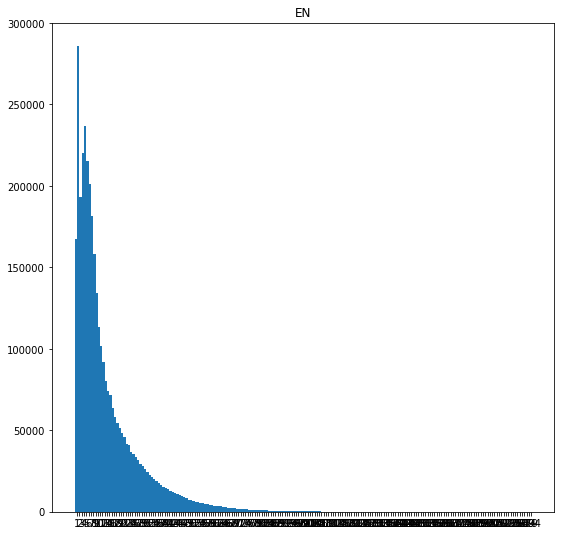

In [107]:
draw_bar_plot("EN", c.corpus_sentence_counter(en_parice_pipeline[REGEXP]))
    

<IPython.core.display.Javascript object>


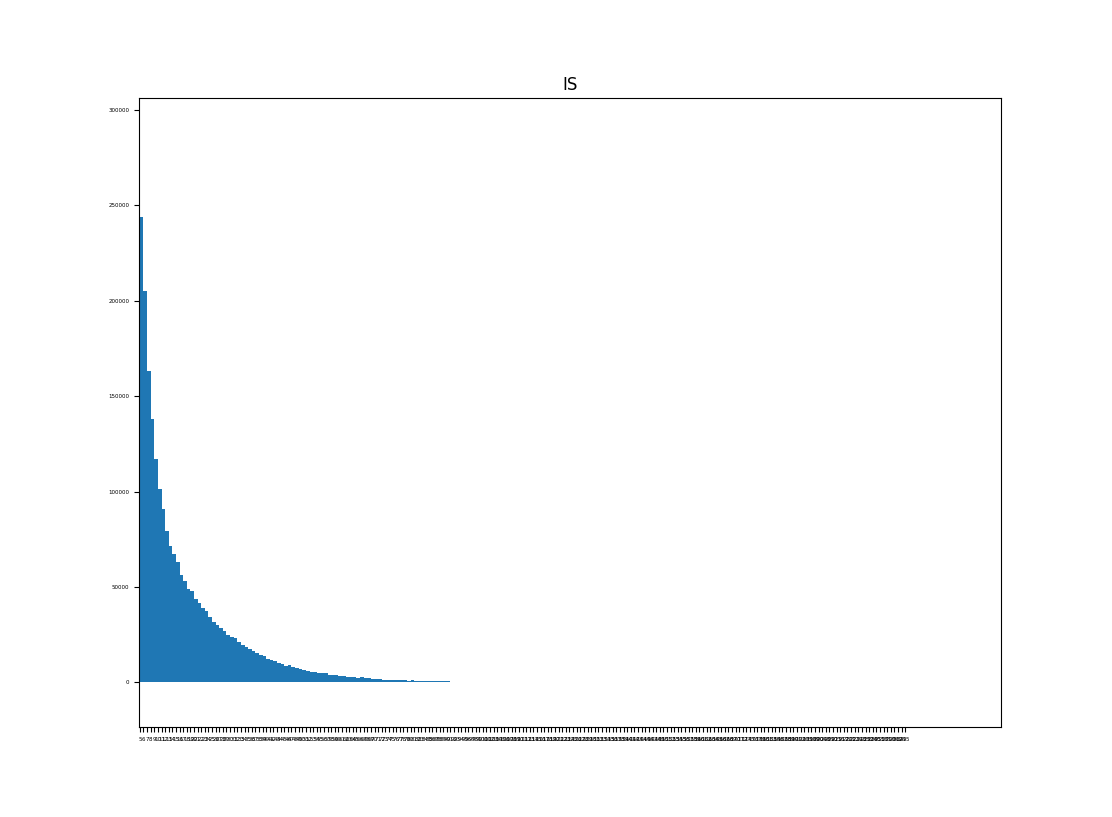

In [46]:
draw_bar_plot("IS", c.corpus_sentence_counter(is_parice_pipeline[REGEXP]))
    

<IPython.core.display.Javascript object>


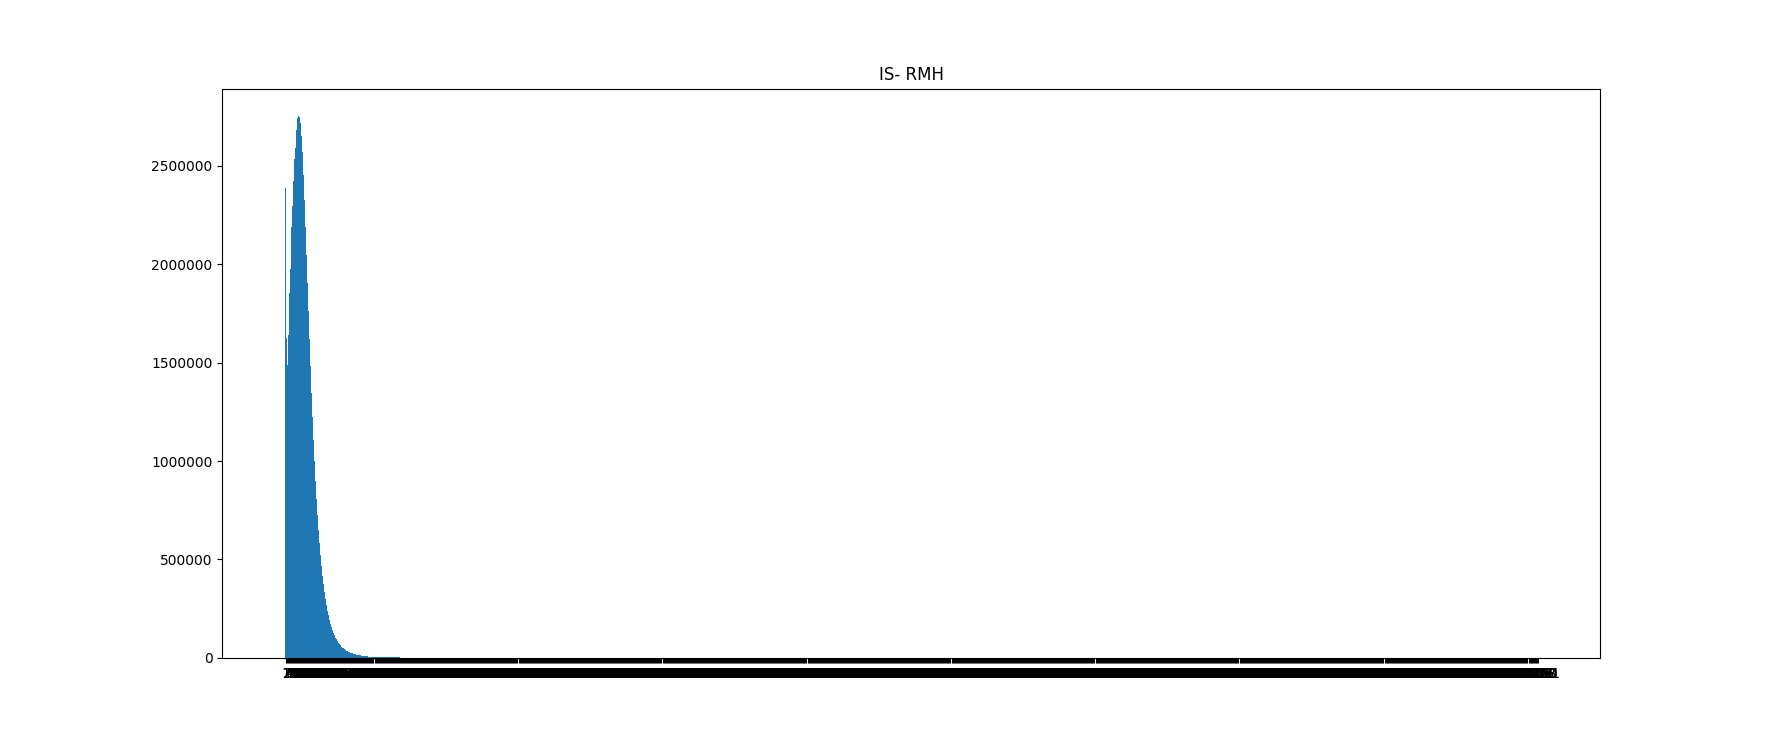

In [45]:
draw_bar_plot("IS- RMH", c.corpus_sentence_counter(rmh_pipeline[REGEXP]))

### Fjöldi tákna og tíðni

In [109]:
en_counter = c.corpus_token_counter(en_parice_pipeline[REGEXP])
is_counter = c.corpus_token_counter(is_parice_pipeline[REGEXP])

In [26]:
rmh_counter = c.corpus_token_counter(rmh_pipeline[REGEXP])

Fjöldi mismunandi orða.

In [110]:
pprint(len(en_counter))
pprint(len(is_counter))

377617
630224


In [48]:
pprint(len(rmh_counter))

5511718


In [ ]:
def token_known_fraction(known_tokens, sentence):
    

In [49]:
import random
pprint(random.sample(rmh_counter.most_common(), 30))

[('lóðaleiguhafar', 6),
 ('torrish', 1),
 ('begrundet', 1),
 ('lostafyllra', 3),
 ('kúskaleikanna', 2),
 ('ákvaðnir', 1),
 ('fermingabæklingi', 1),
 ('sojko', 3),
 ('óáægja', 1),
 ('náttúrutengsl', 9),
 ('afríkunefnd', 1),
 ('hajek', 30),
 ('ituero', 2),
 ('eilífðarmálþóf', 1),
 ('dimmufuglinn', 1),
 ('bænasöngur', 3),
 ('tolosa', 20),
 ('60209', 1),
 ('olmatello', 3),
 ('siðferðiskvíðanum', 1),
 ('hitaofn', 2),
 ('hrognatalan', 2),
 ('merkisbönd', 1),
 ('bloodí', 1),
 ('greiningardæmis', 7),
 ('vöruskortsárunum', 1),
 ('kórdeildin', 1),
 ('grundvallarréttarregla', 1),
 ('sjónvarpsþáttapersónur', 1),
 ('lyftingasali', 2)]


Fjöldi orða.

In [112]:
pprint(f"{'Ensk orð: ':<20}{sum(value for key, value in en_counter.items()):>15}")
pprint(f"{'Íslensk orð: ':<20}{sum(value for key, value in is_counter.items()):>15}")

'Ensk orð:                  50010792'
'Íslensk orð:               46798771'


### Slæmar línur
Sumar línur innihalda ekki góð gögn. Dæmi um slæmar línur eru línur sem innihalda hvorki íslensk né enskar orð, íslenskar setningar innihalda mörg ensk orð, setningar sem innihalda mikið af texta úr öðru máli
3542841, 3543522, 3544806, 108198, 841961, 1926329, 694806, 2414852, 3543522, 1064877, 1138771, 1143444

In [ ]:
IS:('timing', 1),
 ('entering', 1),
 ('purchaser', 1),
    reductions
    лоза
    symptomatic
EN: Ψuχάρη
    Níκαια
    rūgušpiens
    Георги

In [56]:
word = "timing".casefold()
is_file = pipeline[TOKENIZE].IS.get_filepath()
en_file = pipeline[TOKENIZE].EN.get_filepath()
!grep -n -C 2 {word} {is_file}
!grep -n -C 2 {word} {en_file}

2215208-um breyttar skilgreiningar á undirvísitölum : commission regulation ( ec ) no 1749 / 1999 of 23 july 1999 amending regulation ( ec ) no 2214 / 96 , concerning the sub - indices of the harmonized indices of consumer prices ( oj l 214 , 13.8.1999 , p . 1 )
2215209-um reglur við að taka menntun og heilsugæslu inn í vísitöluna : council regulation ( ec ) no 2166 / 1999 of 8 october 1999 laying down detailed rules for the implementation of regulation ( ec ) no 2494 / 95 as regards minimum standards for the treatment of products in the health , education and social protection sectors in the harmonized index of consumer prices ( oj l 266 , 14.10.1999 , p . 1 )
2215210:um hvenær taka á verð með í útreikninginn : commision regulation ( ec ) no 2601 / 2000 of 17 november 2000 laying down detailed rules for the implementation of regulation ( ec ) no 2494 / 95 as regards the timing of entering purchaser prices into the harmonized index of consumer prices ( oj l 300 , 29.11.2000 , p . 14 )


--
454233-the assessment shall cover the phases and characteristics as indicated in table ii . 5 of annex ii to this tsi .
454234-• implementing the maintenance tsi
454235:• implementation procedure and timing
454236-• procedure
454237-the implementation of the specifications on maintenance equipment are based on the following general steps :
--
454240-step 2 :
454241-an economic study is carried out by both the infrastructure manager and the railway undertaking , on the basis of which the initial roster may be modified .
454242:• timing
454243-because of :
454244-• the time needed to build or modify the fixed installations , and to put into place the mobile toilet discharge trolleys ,
454245-• the principle by which compliance with interoperability requirements of the already existing fixed installations is only possible if incorporated into long - term renewal and repair schedules ,
454246:the timing of implementation will have to be negotiated between the infrastructure manager and 

--
912276-body weight may be the best indicator of physical development .
912277-measure ment of developmental landmarks is , therefore , recommended only when there is prior evidence that these endpoints will provide additional information .
912278:timing for the assessment of these parameters is indicated in table 1. depending on the anticipated effects , and the results of the initial measurements , it may be advisable to add ad ditional time points or to perform the measurements in other developmental stages .
912279-• it is advisable to use post - coital age instead of postnatal age when assessing physical development ( 33 ) .
912280-if pups are tested on the day of weaning , it is recommended that this testing be carried out prior to actual weaning to avoid a confounding effect by the stress associated with weaning .
912281-in addition , any post - weaning testing of pups should not occur during the two days after weaning .
912282-table 1
912283:timing of the assessment of physic

--
1376680-however , self - review threats can arise if , for example , there is not a clear separation between the management and control of the internal audit and the internal audit activities themselves , or if the statutory auditor's evaluation of his audit client's internal control system determines the kind and volume of his subsequent statutory audit procedures .
1376681-to avoid such threats , the statutory auditor , the audit firm or its network member must be able to show that it is not involved in management and control of the internal audit .
1376682:furthermore , in his capacity as the statutory auditor of the client's financial statements the statutory auditor must be able to demonstrate that he has taken appropriate steps to have the results of the internal audit work reviewed and has not placed undue reliance on these results in establishing the nature , timing and extent of his statutory audit work .
1376683-in order to ensure that the audit firm's statutory audit work

--
1932812-if you are not ovulating and have irregular or no periods
1932813-if you are not ovulating and have irregular or no periods .
1932814:if you are not ovulating and if the recommended dose and timing are followed , the occurrence of ohss is less likely .
1932815-if you are not ovulating , have no periods and have been diagnosed with very low levels of fsh and lh hormones
1932816-if you are not ovulating , having no periods and have been diagnosed with very low levels of fsh and lh hormones
--
1944478-immunogenicity and safety of ixiaro in children and adolescents from a jev - endemic country
1944479-immunogenicity and safety of prevenar 13 has been demonstrated in adults aged 18 years and older including those previously vaccinated with a pneumococcal polysaccharide vaccine .
1944480:immunogenicity assay results are highly dependent on several factors including assay sensitivity and specificity , assay methodology , assay robustness to quantities of gazyvaro / antibody in the 

2487683-i ain't gonna ask you again .
2487684-shut up , doris .
2487685:keep timing .
2487686-hey , mae , how long ?
2487687-boy , that was some good peeing .
--
2489599-if i leave it on the stock too long , it rots on the way to market .
2489600-too much rain turns it mouldy , too little and it's hog - feed .
2489601:timing's everything .
2489602-same as in my business .
2489603-you gotta pick'em while they're ripe .
--
2510883-good day , sir .
2510884-it's turning the eggs .
2510885:perfect timing .
2510886-i ‚ d hoped they ‚ d hatch before i had to go to the boat .
2510887-henry , why didn't you tell me ?
--
2513710-i started making notes about what he meant to me : surrogate father , mentor , you know .
2513711-i started to get very thirsty .
2513712:not the greatest timing .
2513713-you're here to study law , not keep me sober .
2513714-it's alice .
--
2522230-scar ?
2522231-drop him .
2522232:impeccable timing , your majesty .
2522233-why , if it isn't my big brother descending f

--
3408438-yes .
3408439-but she changed .
3408440:it's about timing .
3408441-and the first time around , we weren't ready to work at it and now we are .
3408442-and besides , caroline is way hotter than that voice in my head who sounds like tom waits and tells me i'm a failure and i look bad in hats .
--
3408483-take off your skis and wait for your family in the lodge , jessica day .
3408484-look , this could be good .
3408485:paul and i had bad timing before .
3408486-and maybe i should just give it another shot .
3408487-such an ugly crier .
--
3408793-and it made me realize something .
3408794-you're wrong .
3408795:all the stuff you said about caroline being about timing and it just making sense ?
3408796-because if you really love someone , it's simple .
3408797-i understand what you're saying , but - you deserve something amazing .
--
3424749-william is better looking .
3424750-and he's a great guy .
3424751:and she's here being a two - timing …
3424752-whore . montana . taylor

In [57]:
!sed '39799q;d' {rmh_pipeline[LOWER]}

í heimaréttinni eru eftirfarandi flipar < hrossin m m > undir þeim flipa eru öll hross listuð upp sem eru í heimaréttinni


In [55]:
!grep -n '@lt@' -m 3 {rmh_pipeline[PLACEHOLDERS]}

39799:í heimaréttinni eru eftirfarandi flipar @lt@ hrossin m m @gt@ undir þeim flipa eru öll hross listuð upp sem eru í heimaréttinni
39802:@lt@ fyljanaskr @gt@ þar er listi yfir allar hryssur í eigu ræktanda
39809:@lt@ fang- og og folaldask folaldask @gt@ hér fer fram skráning á folöldunum og hvað um þau verður


### Tungumála módel
Við notum svo KenLM tungumála módelið til þess að gefa okkur líkindi setninga. Til að flýta uppflettingum þá tungumála módelið samtímis kjörsniðið.

In [72]:
def create_lm(path, out_path, order):
    tmp_arpa = c.corpus_create_path(path, 'arpa')
    !{os.getenv('MOSESDECODER')}/bin/lmplz --order {order} --temp_prefix {data_dir}/ --memory 70% < {path} > {tmp_arpa}
    !{os.getenv('MOSESDECODER')}/bin/build_binary -S 70% {tmp_arpa} {out_path}
    return True

In [ ]:
is_parice_pipeline[LM] = c.corpus_create_path(is_parice_pipeline[PLACEHOLDERS], LM)
en_parice_pipeline[LM] = c.corpus_create_path(en_parice_pipeline[PLACEHOLDERS], LM)

create_lm(is_parice_pipeline[PLACEHOLDERS], is_parice_pipeline[LM], order=3)
create_lm(en_parice_pipeline[PLACEHOLDERS], en_parice_pipeline[LM], order=3)

### Sameina RMH og IS ParIce fyrir mállíkan

In [64]:
rmh_pipeline[CAT] = c.corpus_create_path(rmh_pipeline[PLACEHOLDERS], CAT)
c.corpora_combine((is_parice_pipeline[PLACEHOLDERS], rmh_pipeline[PLACEHOLDERS]), rmh_pipeline[CAT])

True

### EN-IS þýðingarvél

In [17]:
base_model_dir = working_dir.joinpath('en-is/base')
tuned_model_dir = working_dir.joinpath('en-is/tuned')
binarised_model_dir = working_dir.joinpath('en-is/binarised')

base_moses_ini = base_model_dir.joinpath('model/moses.ini')
base_phrase_table = base_model_dir.joinpath('model/phrase-table.gz')
base_reordering_table = base_model_dir.joinpath('model/reordering-table.wbe-msd-bidirectional-fe.gz')

tuned_moses_ini = tuned_model_dir.joinpath('moses.ini')

binarised_moses_ini = binarised_model_dir.joinpath('moses.ini')
binarised_phrase_table = binarised_model_dir.joinpath('phrase-table')
binarised_reordering_table = binarised_model_dir.joinpath('reordering-table')

In [4]:
print(*c.corpus_peek(en_parice_pipeline[TRANSLATED_EN_IS]))

matt , þú getur ekki að heyra þetta núna en það er ekki hennar sök . 
 hann gerði ? 
 vii . aðrar afurðir landdýra ( villt veiðidýr ) 
 lettland 
 reglugerð ( eb ) númer 78 / 2009 
 þeir ætluðu að drepa hann . 
 „ einungis ætlað til notkunar á afmörkuðum landsvæðum ef um er að ræða mengun af völdum geisla - án tímamarka 
 svo fara eftir þeim . 
 skuldbindingar aðila lánastofnana sem starfa sem samvinnufélög , sem um getur í 1. málsgrein 2. grein ( 7 ) , skal ná til ógreidds stofnfjár þessara félaga ásamt skuldbindingum aðila slíkra samvinnufélaga lögum samkvæmt til að þau f hendi óendurkræfar aukagreiðslur verði lánastofnunin fyrir tapi og er þá heimilt að vera unnt að krefjast slíkra greiðslna án tafar . 
 tot , 15 mínútur . 



### Demo
Þýða einhvern texta.

In [6]:
def translate_en_is(moses_ini, sentence):
    sentence = c.sent_process_v1(sentence, c.Lang.EN)
    !echo "{sentence}" | {os.getenv('MOSESDECODER')}/bin/moses -f {moses_ini}

In [10]:
sentence = "English sentence."
print(translate_en_is(binarised_moses_ini, sentence))

Defined parameters (per moses.ini or switch):
	config: /work/en-is/binarised/moses.ini 
	distortion-limit: 6 
	feature: UnknownWordPenalty WordPenalty PhrasePenalty PhraseDictionaryCompact name=TranslationModel0 num-features=4 path=/work/en-is/binarised/phrase-table input-factor=0 output-factor=0 LexicalReordering name=LexicalReordering0 num-features=6 type=wbe-msd-bidirectional-fe-allff input-factor=0 output-factor=0 path=/work/en-is/binarised/reordering-table Distortion KENLM name=LM0 factor=0 path=/work/en-is/binarised/lm-is.blm order=3 
	input-factors: 0 
	mapping: 0 T 0 
	threads: 14 
	weight: LexicalReordering0= 0.0289401 0.00216597 0.102201 0.0376488 -0.0181822 0.0658433 Distortion0= 0.0166935 LM0= 0.149235 WordPenalty0= -0.204966 PhrasePenalty0= 0.126341 TranslationModel0= 0.0991475 0.0160094 0.128108 0.00451765 UnknownWordPenalty0= 1 
line=UnknownWordPenalty
FeatureFunction: UnknownWordPenalty0 start: 0 end: 0
line=WordPenalty
FeatureFunction: WordPenalty0 start: 1 end: 1
line

In [8]:
sentence = "The event was created by Matty Roberts , [ 1 ] who confirmed it was comedic and disavowed responsibility for any casualties if people actually attempt to raid the military base."
print(translate_en_is(binarised_moses_ini, sentence))

Defined parameters (per moses.ini or switch):
	config: /work/en-is/binarised/moses.ini 
	distortion-limit: 6 
	feature: UnknownWordPenalty WordPenalty PhrasePenalty PhraseDictionaryCompact name=TranslationModel0 num-features=4 path=/work/en-is/binarised/phrase-table input-factor=0 output-factor=0 LexicalReordering name=LexicalReordering0 num-features=6 type=wbe-msd-bidirectional-fe-allff input-factor=0 output-factor=0 path=/work/en-is/binarised/reordering-table Distortion KENLM name=LM0 factor=0 path=/work/en-is/binarised/lm-is.blm order=3 
	input-factors: 0 
	mapping: 0 T 0 
	threads: 14 
	weight: LexicalReordering0= 0.0289401 0.00216597 0.102201 0.0376488 -0.0181822 0.0658433 Distortion0= 0.0166935 LM0= 0.149235 WordPenalty0= -0.204966 PhrasePenalty0= 0.126341 TranslationModel0= 0.0991475 0.0160094 0.128108 0.00451765 UnknownWordPenalty0= 1 
line=UnknownWordPenalty
FeatureFunction: UnknownWordPenalty0 start: 0 end: 0
line=WordPenalty
FeatureFunction: WordPenalty0 start: 1 end: 1
line

### IS-EN þýðingarvél

In [25]:
base_model_dir = working_dir.joinpath('is-en/base')
tuned_model_dir = working_dir.joinpath('is-en/tuned')
binarised_model_dir = working_dir.joinpath('is-en/binarised')

base_moses_ini = base_model_dir.joinpath('model/moses.ini')
base_phrase_table = base_model_dir.joinpath('model/phrase-table.gz')
base_reordering_table = base_model_dir.joinpath('model/reordering-table.wbe-msd-bidirectional-fe.gz')

tuned_moses_ini = tuned_model_dir.joinpath('moses.ini')

binarised_moses_ini = binarised_model_dir.joinpath('moses.ini')
binarised_phrase_table = binarised_model_dir.joinpath('phrase-table')
binarised_reordering_table = binarised_model_dir.joinpath('reordering-table')

In [11]:
def translate_is_en(moses_ini, sentence):
    sentence = c.sent_process_v1(sentence, c.Lang.IS)
    !echo "{sentence}" | {os.getenv('MOSESDECODER')}/bin/moses -f {moses_ini}

In [12]:
sentence = "Ég man ekki eftir neinum góðum myndum nýlega "
print(translate_is_en(binarised_moses_ini, sentence))

Defined parameters (per moses.ini or switch):
	config: /work/is-en/binarised/moses.ini 
	distortion-limit: 6 
	feature: UnknownWordPenalty WordPenalty PhrasePenalty PhraseDictionaryCompact name=TranslationModel0 num-features=4 path=/work/is-en/binarised/phrase-table input-factor=0 output-factor=0 LexicalReordering name=LexicalReordering0 num-features=6 type=wbe-msd-bidirectional-fe-allff input-factor=0 output-factor=0 path=/work/is-en/binarised/reordering-table Distortion KENLM name=LM0 factor=0 path=/work/data/parice/lm-blm.en order=3 
	input-factors: 0 
	mapping: 0 T 0 
	threads: 14 
	weight: LexicalReordering0= 0.0839657 0.0592771 0.116033 0.0510411 0.0145316 0.103368 Distortion0= -0.0145896 LM0= 0.11677 WordPenalty0= -0.187629 PhrasePenalty0= -0.0271079 TranslationModel0= 0.0655779 0.0246838 0.134754 0.000671537 UnknownWordPenalty0= 1 
line=UnknownWordPenalty
FeatureFunction: UnknownWordPenalty0 start: 0 end: 0
line=WordPenalty
FeatureFunction: WordPenalty0 start: 1 end: 1
line=Phr

In [13]:
sentence = "já, einmitt"
print(translate_is_en(binarised_moses_ini, sentence))

Defined parameters (per moses.ini or switch):
	config: /work/is-en/binarised/moses.ini 
	distortion-limit: 6 
	feature: UnknownWordPenalty WordPenalty PhrasePenalty PhraseDictionaryCompact name=TranslationModel0 num-features=4 path=/work/is-en/binarised/phrase-table input-factor=0 output-factor=0 LexicalReordering name=LexicalReordering0 num-features=6 type=wbe-msd-bidirectional-fe-allff input-factor=0 output-factor=0 path=/work/is-en/binarised/reordering-table Distortion KENLM name=LM0 factor=0 path=/work/data/parice/lm-blm.en order=3 
	input-factors: 0 
	mapping: 0 T 0 
	threads: 14 
	weight: LexicalReordering0= 0.0839657 0.0592771 0.116033 0.0510411 0.0145316 0.103368 Distortion0= -0.0145896 LM0= 0.11677 WordPenalty0= -0.187629 PhrasePenalty0= -0.0271079 TranslationModel0= 0.0655779 0.0246838 0.134754 0.000671537 UnknownWordPenalty0= 1 
line=UnknownWordPenalty
FeatureFunction: UnknownWordPenalty0 start: 0 end: 0
line=WordPenalty
FeatureFunction: WordPenalty0 start: 1 end: 1
line=Phr